# Analyses MooneyTD task in AQ trait (students) and ASD (adolescents)

**Researchers: Sander Van de Cruys, Ines Van de Put (MA thesis student), Steven Vanmarcke (data collection), Johan Wagemans**
___


Notes:
* All errorbars are **95% CIs**
* Mooney (pretest, exposure phase, posttest; "MooneyTD")
* dependent vars: recognition acc and count (number of guesses irrespective of accurate recognition, could also give a measure of "top-down generative strength").


* 1s target duration
* 2s template duration
* 750ms iti


Mooney task based on: 

> Teufel, C., Subramaniam, N., Dobler, V., Perez, J., Finnemann, J., Mehta, P. R., … Fletcher, P. C. (2015). Shift toward prior knowledge confers a perceptual advantage in early psychosis and psychosis-prone healthy individuals. Proceedings of the National Academy of Sciences of the United States of America, 112(43), 13401–13406.

*Study 1*:

* About 300 subjects (students)
* AQ traits measured

*Study 2*:

* 25 participants in each group (adolescents, matched on IQ and gender by Steven)
* notes: 223 (under ados cutoff) & 204/229 (acc lower than .2)

In [1]:
import numpy as np
import pandas as pd
import csv, json
from fuzzywuzzy import fuzz

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from __future__ import print_function
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.weightstats import ttest_ind
from bambi import Model, Family, Prior #Bayesian model building

%pylab inline
sns.set(style="whitegrid")
sns.set_context("talk")

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Load the IPython magic extension to use R within this notebook and import external R packages we'll use.

In [2]:
%load_ext rpy2.ipython
%R -n library(lme4)

/usr/local/lib/python2.7/dist-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Loading required package: Matrix

  warnings.warn(x, RRuntimeWarning)


Define an R function to facilitate reporting of likelihood ratio test of nested LMEMs.

In [3]:
%%R
lr.test = function(m1, m2, name){
    print(summary(m1))
    print(summary(m2))
    out = anova(m1, m2)
    chi2 = out$Chisq[2]
    dof = out$"Chi Df"[2]
    p = out$"Pr(>Chisq)"[2]
    test_str = "Likelihood ratio test for %s:\n  Chisq(%d) = %.2f; p = %.3g"
    writeLines(sprintf(test_str, name, dof, chi2, p))
}

Control saving figures globally with this function so it is easy to switch between file types and possibly other options.

In [4]:
def save_fig(fig, figname):
    fig.savefig("figs/%s.pdf" % figname, dpi=300)
    fig.savefig("figs/%s.png" % figname, dpi=300)
    fig.savefig("figs/%s.svg" % figname, dpi=300)

# Study 1: Correlating AQ with Mooney performance

**!!! Don't run this again, import preprocessed data below (starting section 2.4) !!!**

## Scoring AQ

In [ ]:
#starting from raw google form data

df = pd.read_csv("AQ_Data/AQCOdec2015.csv")

labels = ["id","sex","age"]

items= [str(x+1) for x in range(50)]
labels=labels+items

df.columns = labels

In [ ]:
#starting from clean data
df = pd.read_csv("AQ_Data/COdec2015AQ.csv")
df.head()


In [ ]:
repsOptions= {"Definitely agree":1, "Slightly agree": 2, 
              "Slightly disagree":3, "Definitely disagree":4}


qLow= [1, 2, 4, 5, 6, 7, 9, 12, 13, 16, 18, 19, 20, 21, 22, 23, 26, 33, 35, 
       39, 41, 42, 43, 45, 46]

qHigh= [3, 8, 10, 11, 14, 15, 17, 24, 25, 27, 28, 29, 30, 31, 32, 34, 36, 
        37, 38, 40, 44, 47, 48, 49, 50]

# items for subscales: Baron-Cohen
socialskill = [1,11,13,15,22,36,44,45,47,48] 
attswitch = [2,4,10,16,25,32,34,37,43,46] 
attdetail = [5,6,9,12,19,23,28,29,30,49] 
comm = [7,17,18,26,27,31,33,35,38,39] 
imagination = [3,8,14,20,21,24,40,41,42,50]

""" In the first major trial using the test, 
the average score in the control group was 16.4. 
Eighty percent of those diagnosed with autism or 
a related disorder scored 32 or higher. 
The test is not a means for making a diagnosis, 
however, and many who score above 32 and even 
meet the diagnostic criteria for mild autism or 
Asperger’s report no difficulty functioning 
.in their everyday lives. from http://aspergerstest.net/interpreting-aq-test-results/"""

def scoreBC(row):
    """ score binary like original Baron-Cohen"""
    aqscore=0
    
    for i in qLow:
        if row[str(i)] <=2 :
            aqscore+=1
        
    for i in qHigh:
        if row[str(i)] > 2 :
            aqscore+=1
            
               
    return aqscore

def scoreLikert(row):
    """ score 4-point likert """
    likertscore=0
    
    for i in qLow:
        likertscore += 5-row[str(i)]
        
    for i in qHigh:
        likertscore += row[str(i)]
            
               
    return likertscore

def scoresubscale(row, sub):
    """ score on nonsocial items"""
    
    subscore=0
    
    for i in sub:
        if i in qLow:
            subscore += 5-row[str(i)]

        if i in qHigh:
            subscore += row[str(i)]

               
    return subscore

df['AQ'] = df.apply(scoreBC, axis=1)
df['AQlikert'] = df.apply(scoreLikert, axis=1)
df['AQattDetail'] = df.apply(scoresubscale, axis=1, args=([attdetail]))
df['AQsocialSkill'] = df.apply(scoresubscale, axis=1, args=([socialskill]))
df['AQattSwitch'] = df.apply(scoresubscale, axis=1, args=([attswitch]))
df['AQcomm'] = df.apply(scoresubscale, axis=1, args=([comm]))
df['AQimagination'] = df.apply(scoresubscale, axis=1, args=([imagination]))


In [ ]:
df[['id','AQ']]
df.to_csv("AQ_Data/COdec2015AQ.csv")

df.head()

## Preprocessing mooneyTD

In [ ]:
with open('AQ_Data/mooneyTDCOdec2015.csv', 'Ur') as f:
    data = list(list(rec) for rec in csv.reader(f, delimiter='\t'))

expandata=[]

print len(data)
expandata.append(["id", "trialnb", "blocknb", "prepost", "stim", "response", "rt"])

#print data[1][2]


for i,row in enumerate(data):
    
    
    if i==0:
        continue
    else:
        trials=row[2].split('\n')
        
        for trial in trials:
            
            trial = trial.strip('[]')
            if trial=="": continue
            trial = trial.split(',')            
            expandata.append(trial)

print len(expandata)

with open("AQ_Data/datMooneyTD.csv", "wb") as f:
    writer = csv.writer(f)
    writer.writerows(expandata)

## Correct responses with answer key


In [37]:

df = pd.read_csv("AQ_Data/datMooneyTD.csv")


def correct(df):


    rk = pd.read_csv("mooneyanswerkey.csv",delimiter='\t')
    acccol = []
    correctRespcol = []
        
    
    for rowNb, row in df.iterrows():


        answer = str(row['response'])
        acc=0
        

        if answer!='':
            answer=answer.lower()

            img= row['stim']

            img=img.split('http://www.tureluurs.be/onlineExp/mooneyTD/')
        
            img=img[1].strip('"')
            
            sols= rk.sol[rk['tt'] == img]
            sols=np.array(sols)[0].split(',')
            correctResp=sols

            for i in sols:
                i.strip()
                if fuzz.ratio(i,answer) > 70:
                    acc=1
                    break

        acccol.append(acc)
        correctRespcol.append(correctResp)

    df['acc'] = acccol
    df['correctResp'] = correctRespcol
    #print acccol
    return df    

df = correct(df)
df.head()
df.to_csv('AQ_Data/dataMooneyTDwithAcc.csv')

## Preprocessing done

In [9]:
df= pd.read_csv('AQ_Data/dataMooneyTDwithAcc.csv')
df["blocknb"]=df.blocknb + 1 #block starts from 0 instead of 1
df.head()

,Unnamed: 0,id,trialnb,blocknb,prepost,stim,response,rt,Unnamed: 7,acc,correctResp
0,0,20524,0,1,pre,http://www.tureluurs.be/onlineExp/mooneyTD/img...,krokodil,3308,NaN,0,"['slang', ' slangenkop', ' snake']"
1,1,20524,1,1,pre,http://www.tureluurs.be/onlineExp/mooneyTD/img...,leeuw,2715,NaN,0,"['waterkan', ' kan', ' fles', ' pitcher', 'kru..."
2,2,20524,2,1,pre,http://www.tureluurs.be/onlineExp/mooneyTD/img...,mens,3286,NaN,0,"['sandwich', ' boterham', ' broodje']"
3,3,20524,3,1,pre,http://www.tureluurs.be/onlineExp/mooneyTD/img...,aap,3245,NaN,0,"['kever', ' insect', ' beestje', ' wants', ' b..."
4,4,20524,4,1,pre,http://www.tureluurs.be/onlineExp/mooneyTD/img...,neus,2828,NaN,0,"['trein', ' train', ' locomotief', ' wagon', '..."


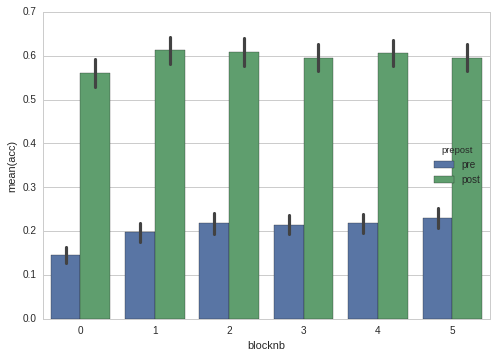

In [3]:
sns.barplot(x="blocknb", y="acc", hue="prepost", units="id",data=df);

## Check stimuli to be removed?

In [10]:
# groupby stim to see which stimuli are too difficult, don't give high enough diff score
print(len(df['stim'].unique()))

dfstim = df.groupby(['stim', 'prepost']).acc.mean() 
dfstim = dfstim.reset_index()
dfstim.head()
#dfstim.to_csv("AQ_Data/COaccByStim.csv")

120


,stim,prepost,acc
0,http://www.tureluurs.be/onlineExp/mooneyTD/img...,post,0.855346
1,http://www.tureluurs.be/onlineExp/mooneyTD/img...,pre,0.490566
2,http://www.tureluurs.be/onlineExp/mooneyTD/img...,post,0.153846
3,http://www.tureluurs.be/onlineExp/mooneyTD/img...,pre,0.000000
4,http://www.tureluurs.be/onlineExp/mooneyTD/img...,post,0.686275


In [11]:
# check stims that are too difficult

stims = dfstim.stim.loc[(dfstim.prepost=="post") & (dfstim.acc<.2)]

print(len(df))
print(len(stims))

for stim in stims:
    df = df[df.stim!=stim]

print(len(df))
print(len(df['stim'].unique()))

36600
3
35686
117


## Check individuals to be removed?

In [12]:
#groupby individuals
print(len(df['id'].unique()))

dfid = df.groupby(['id', "prepost"]).acc.mean()
dfid = dfid.reset_index()
dfid.head()

ids = dfid.id.loc[(dfid.prepost=="post") & (dfid.acc<.2)]

print(len(df))
print(len(ids))

for id in ids:
    df = df[df.id!=id]
    dfid = dfid[dfid.id!=id]

print(len(df))
print(len(df['id'].unique()))


299
35686
14
34042
285


## Is there improvement across blocks?

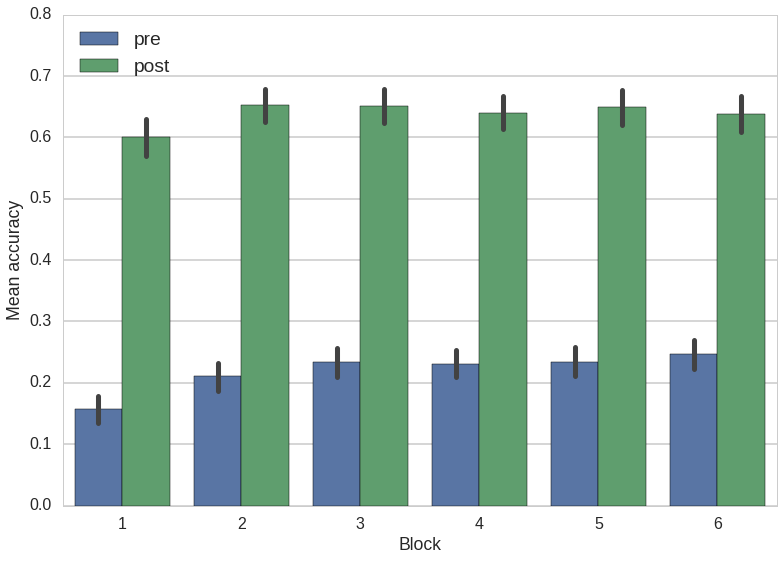

In [9]:
sns.set_context("poster")
sns.set_style("whitegrid")
f, ax = plt.subplots()
sns.barplot(x="blocknb", y="acc", hue="prepost", units="id",data=df);
ax.legend(title="", ncol=1, loc="upper left", fontsize='medium');
ax.set(ylabel="Mean accuracy", xlabel="Block", ylim=(0,.8));
save_fig(f, "AQblockAcc")

## Merge AQ data and mooney data

In [13]:
dfAQ = pd.read_csv("AQ_Data/COdec2015AQ.csv")

# add AQ standardized scores
for i in ["AQ", "AQimagination","AQcomm", "AQsocialSkill", "AQattSwitch", "AQattDetail"]:
    dfAQ[i+"_s"] = (dfAQ[i] - dfAQ[i].mean()) / dfAQ[i].std()


In [14]:
dfmerged= pd.merge(df, dfAQ, how='outer', on='id')

print(len(dfmerged['id'].unique()))
dfmerged.head()

303


,Unnamed: 0_x,id,trialnb,blocknb,prepost,stim,response,rt,Unnamed: 7,acc,...,AQsocialSkill,AQattSwitch,AQcomm,AQimagination,AQ_s,AQimagination_s,AQcomm_s,AQsocialSkill_s,AQattSwitch_s,AQattDetail_s
0,0.0,20524.0,0.0,1.0,pre,http://www.tureluurs.be/onlineExp/mooneyTD/img...,krokodil,3308,NaN,0.0,...,20.0,24.0,21.0,25.0,-0.713011,1.269891,0.083855,-0.247252,0.023005,-0.534221
1,1.0,20524.0,1.0,1.0,pre,http://www.tureluurs.be/onlineExp/mooneyTD/img...,leeuw,2715,NaN,0.0,...,20.0,24.0,21.0,25.0,-0.713011,1.269891,0.083855,-0.247252,0.023005,-0.534221
2,2.0,20524.0,2.0,1.0,pre,http://www.tureluurs.be/onlineExp/mooneyTD/img...,mens,3286,NaN,0.0,...,20.0,24.0,21.0,25.0,-0.713011,1.269891,0.083855,-0.247252,0.023005,-0.534221
3,3.0,20524.0,3.0,1.0,pre,http://www.tureluurs.be/onlineExp/mooneyTD/img...,aap,3245,NaN,0.0,...,20.0,24.0,21.0,25.0,-0.713011,1.269891,0.083855,-0.247252,0.023005,-0.534221
4,4.0,20524.0,4.0,1.0,pre,http://www.tureluurs.be/onlineExp/mooneyTD/img...,neus,2828,NaN,0.0,...,20.0,24.0,21.0,25.0,-0.713011,1.269891,0.083855,-0.247252,0.023005,-0.534221


In [15]:
#drop rows without AQ or diff

dfmerged = dfmerged.dropna(subset=["AQ","prepost"])
print(len(dfmerged['id'].unique()))
dfmerged.head()

282


,Unnamed: 0_x,id,trialnb,blocknb,prepost,stim,response,rt,Unnamed: 7,acc,...,AQsocialSkill,AQattSwitch,AQcomm,AQimagination,AQ_s,AQimagination_s,AQcomm_s,AQsocialSkill_s,AQattSwitch_s,AQattDetail_s
0,0.0,20524.0,0.0,1.0,pre,http://www.tureluurs.be/onlineExp/mooneyTD/img...,krokodil,3308,NaN,0.0,...,20.0,24.0,21.0,25.0,-0.713011,1.269891,0.083855,-0.247252,0.023005,-0.534221
1,1.0,20524.0,1.0,1.0,pre,http://www.tureluurs.be/onlineExp/mooneyTD/img...,leeuw,2715,NaN,0.0,...,20.0,24.0,21.0,25.0,-0.713011,1.269891,0.083855,-0.247252,0.023005,-0.534221
2,2.0,20524.0,2.0,1.0,pre,http://www.tureluurs.be/onlineExp/mooneyTD/img...,mens,3286,NaN,0.0,...,20.0,24.0,21.0,25.0,-0.713011,1.269891,0.083855,-0.247252,0.023005,-0.534221
3,3.0,20524.0,3.0,1.0,pre,http://www.tureluurs.be/onlineExp/mooneyTD/img...,aap,3245,NaN,0.0,...,20.0,24.0,21.0,25.0,-0.713011,1.269891,0.083855,-0.247252,0.023005,-0.534221
4,4.0,20524.0,4.0,1.0,pre,http://www.tureluurs.be/onlineExp/mooneyTD/img...,neus,2828,NaN,0.0,...,20.0,24.0,21.0,25.0,-0.713011,1.269891,0.083855,-0.247252,0.023005,-0.534221


## Descriptive participant stats

In [8]:
# compute proper ages
dfmerged.loc[:,"agec"] = dfmerged.age.str.split('/').str[-1]
dfmerged.agec = pd.to_numeric(dfmerged.agec, errors='coerce')
dfmerged.agec.loc[dfmerged.agec<50] = dfmerged.agec + 2000
dfmerged.agec.loc[(dfmerged.agec>50) & (dfmerged.agec<100)] = dfmerged.agec + 1900
dfmerged.agec.loc[dfmerged.agec == 7041996]=1996
dfmerged.agec = 2015 - dfmerged.agec
dfmerged.agec.loc[dfmerged.agec == 3] = 19 # invalid year

/usr/local/lib/python2.7/dist-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [13]:
#Sex and age
sex = dfmerged.groupby(['id']).sex.apply(lambda x: x.iloc[0]) #number of males
print(len(sex[sex=="Man"]))
dfmerged.groupby(['id']).agec.mean().describe()

40


count    282.000000
mean      18.602837
std        1.908510
min       17.000000
25%       18.000000
50%       18.000000
75%       19.000000
max       39.000000
Name: agec, dtype: float64

In [155]:
# AQlikert statistics
dfmerged.groupby(['id']).AQlikert.mean().describe().T

count    282.000000
mean     108.657801
std       14.684612
min       71.000000
25%       99.000000
50%      108.000000
75%      117.750000
max      158.000000
Name: AQlikert, dtype: float64

In [158]:
# AQ(binary) statistics
dfmerged.groupby(['id']).AQ.mean().describe().T

count    282.000000
mean      17.728723
std        6.608389
min        3.000000
25%       13.000000
50%       17.000000
75%       22.000000
max       43.000000
Name: AQ, dtype: float64

In [198]:
len(dfmerged[dfmerged.AQ >= 32].id.unique())  #number of scores above 32 (informal clinical cut-off)

7

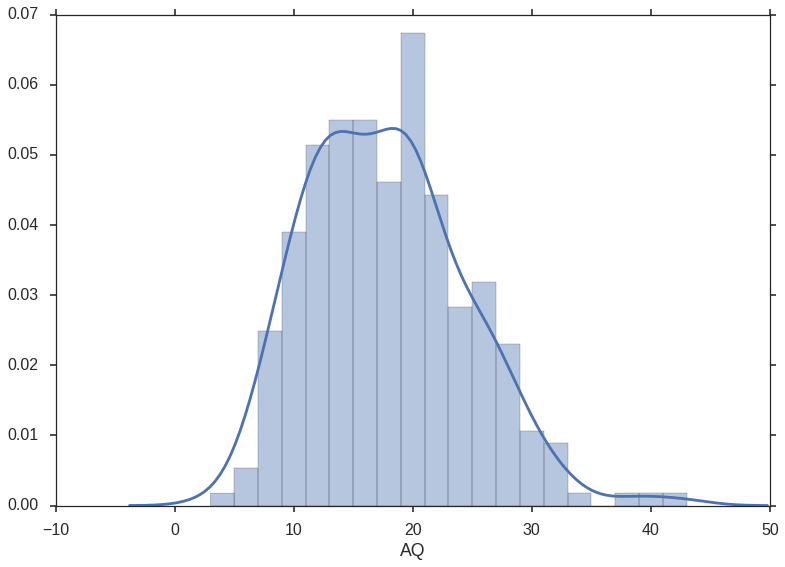

In [173]:
sns.distplot(dfmerged.groupby(['id']).AQ.mean(), bins=20);

## Testing whether AQ is normally distributed

NormaltestResult(statistic=16.024021248091977, pvalue=0.00033145761191318121)
KstestResult(statistic=0.9986501019683699, pvalue=0.0)


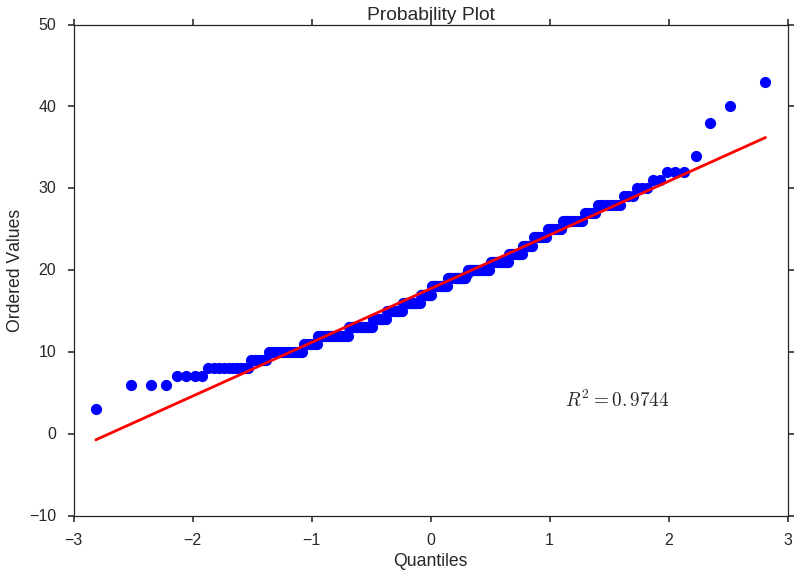

In [180]:
import scipy.stats as stats
print(stats.normaltest(dfmerged.groupby(['id']).AQ.mean()))
print(stats.kstest(dfmerged.groupby(['id']).AQ.mean(), 'norm'))

stats.probplot(dfmerged.groupby(['id']).AQ.mean(), dist="norm", plot=pylab);

In [160]:
dfmerged.to_csv("AQ_Data/COdec2015AQMooneyMerged.csv")

## Plot median split AQ

In [20]:
#add variable median split
dfmerged['AQlevel']= pd.qcut(dfmerged['AQ'],2, labels=['Low AQ','High AQ'])
print(len(dfmerged[dfmerged.AQlevel=="Low AQ"]))

18722


In [21]:
dfgrouped = dfmerged.groupby(['id', "prepost","AQlevel"]).acc.mean()
dfgrouped = dfgrouped.reset_index()
dfgrouped.head()

,id,prepost,AQlevel,acc
0,18019.0,post,Low AQ,0.576271
1,18019.0,pre,Low AQ,0.186441
2,19756.0,post,High AQ,0.610169
3,19756.0,pre,High AQ,0.288136
4,20176.0,post,High AQ,0.711864


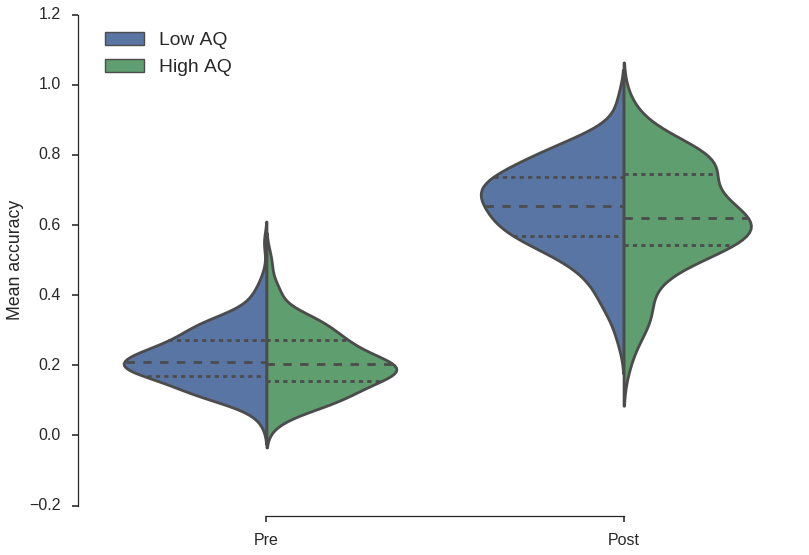

In [163]:
sns.set_context("poster")
sns.set_style("ticks")
f, ax = plt.subplots()
sns.violinplot(x="prepost", y="acc", hue="AQlevel", data=dfgrouped,inner="quartile",\
               split=True, order=["pre","post"]);
#sns.swarmplot(x="prepost", y="acc", hue="AQlevel", data=dfacc, color="w", alpha=.8);
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = 'Pre'
labels[1] = 'Post'
ax.set_xticklabels(labels)
sns.despine(offset=10, trim=True);
ax.legend(title="", ncol=1, loc="upper left", fontsize='medium');
ax.set(ylabel="Mean accuracy", xlabel="");
save_fig(f, "mediansplitAQ_acc_prepost")

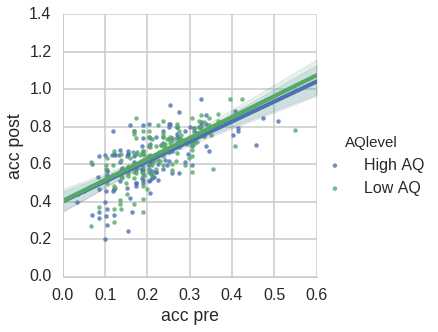

In [26]:
# scatterplot of pre vs post accuracy
dfwide= pd.pivot_table(data=dfgrouped, values=["acc"], index=['id'],columns=['prepost']).reset_index()
dfwide.columns = [' '.join(col).strip() for col in dfwide.columns.values]
dfwide= pd.merge(dfwide, dfgrouped[['id','AQlevel']], how='inner', on='id').drop_duplicates(subset="id")
dfwide.head()

sns.lmplot(x="acc pre", y="acc post",hue="AQlevel", robust=True, data=dfwide);

## Plot & test relation overall AQ score with Mooney performance

* McNeish, D., Stapleton, L. M., & Silverman, R. D. (2016). [On the Unnecessary Ubiquity of Hierarchical Linear Modeling. Psychological Methods](https://drive.google.com/open?id=0BwlD7q-DXkdWWXRWRG5YZUZ1elU). http://doi.org/10.1037/met0000078

In [16]:
# model formulation
fml = "acc ~ AQ_s * prepost * blocknb * sex"

# covariance structure
ex = sm.cov_struct.Exchangeable()
#link fu
fa = sm.families.Binomial(sm.families.links.logit)

model = sm.GEE.from_formula(fml, "id", dfmerged, cov_struct=ex, family=fa)
result = model.fit()
print(result.summary())
print(result.cov_struct.summary())

                               GEE Regression Results                              
Dep. Variable:                         acc   No. Observations:                34156
Model:                                 GEE   No. clusters:                      282
Method:                        Generalized   Min. cluster size:                 114
                      Estimating Equations   Max. cluster size:                 472
Family:                           Binomial   Mean cluster size:               121.1
Dependence structure:         Exchangeable   Num. iterations:                     8
Date:                      vr, 23 sep 2016   Scale:                           1.001
Covariance type:                    robust   Time:                         18:52:48
                                               coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------------------
Intercept                 

In [204]:
np.exp(-2.2719)

0.1031160733013804

## Testing interaction and main effect with R (glmer)

First, we fit both an interactive model and additive model predicting acc and use a likelihood ratio test to see whether the interaction is significant.

In [16]:
%%R -i dfmerged
m = glmer(acc ~ blocknb + blocknb:prepost + prepost * AQ_s + (prepost | id), dfmerged, family=binomial)
m.null = glmer(acc ~ blocknb*prepost + AQ_s + (prepost | id), dfmerged, family=binomial)
lr.test(m, m.null, "interaction effect of prepost*AQ")

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: acc ~ blocknb + blocknb:prepost + prepost * AQ_s + (prepost |      id)
   Data: dfmerged

     AIC      BIC   logLik deviance df.resid 
 39189.3  39265.3 -19585.7  39171.3    34147 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.7687 -0.6091 -0.4237  0.7354  3.3341 

Random effects:
 Groups Name        Variance Std.Dev. Corr 
 id     (Intercept) 0.3278   0.5726        
        prepostpre  0.0434   0.2083   -0.85
Number of obs: 34156, groups:  id, 282

Fixed effects:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)         0.524909   0.050743   10.34  < 2e-16 ***
blocknb             0.022834   0.009656    2.36   0.0180 *  
prepostpre         -2.161850   0.059752  -36.18  < 2e-16 ***
AQ_s               -0.062473   0.037254   -1.68   0.0935 .  
blocknb:prepostpre  0.065759   0.014675    4.48 7.42e-06 ***
prepostpre:AQ_

In [36]:
%%R -i dfmerged
m = glmer(acc ~ prepost + AQ_s + (prepost | id), dfmerged, family=binomial)
m.null = glmer(acc ~ blocknb * prepost + (prepost | id), dfmerged, family=binomial)
lr.test(m, m.null, "Main effect of AQ")

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: acc ~ prepost + AQ + (1 | id)
   Data: dfmerged

     AIC      BIC   logLik deviance df.resid 
 39284.8  39318.6 -19638.4  39276.8    34152 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.3713 -0.6140 -0.4184  0.7359  3.8233 

Random effects:
 Groups Name        Variance Std.Dev.
 id     (Intercept) 0.2476   0.4976  
Number of obs: 34156, groups:  id, 282

Fixed effects:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.727230   0.092584    7.85    4e-15 ***
prepost2    -1.934950   0.025489  -75.91   <2e-16 ***
AQ          -0.007598   0.004856   -1.56    0.118    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
         (Intr) prpst2
prepost2 -0.123       
AQ       -0.930  0.007
Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]


In [28]:
%%R -i dfmerged
m = glmer(acc ~ prepost + (1 | id), dfmerged, family=binomial)
m.null = glmer(acc ~ 1 + (1 | id), dfmerged, family=binomial)
lr.test(m, m.null, "Main effect of prepost")

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: acc ~ prepost + (prepost | id)
   Data: dfmerged

     AIC      BIC   logLik deviance df.resid 
 39254.4  39296.6 -19622.2  39244.4    34151 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.7442 -0.5972 -0.4384  0.7398  3.2474 

Random effects:
 Groups Name        Variance Std.Dev. Corr 
 id     (Intercept) 0.33197  0.5762        
        prepost2    0.04468  0.2114   -0.85
Number of obs: 34156, groups:  id, 282

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.60372    0.03823   15.79   <2e-16 ***
prepost2    -1.92457    0.02865  -67.17   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
         (Intr)
prepost2 -0.594
Likelihood ratio test for Main effect of prepost:
  Chisq(1) = 808.34; p = 8.3e-178


Print the final model

In [7]:
%R print(m, corr=FALSE)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: acc ~ prepost + (prepost | id)
   Data: dfmerged
      AIC       BIC    logLik  deviance  df.resid 
 39254.37  39296.56 -19622.18  39244.37     34151 
Random effects:
 Groups Name        Std.Dev. Corr 
 id     (Intercept) 0.5762        
        prepostpre  0.2114   -0.85
Number of obs: 34156, groups:  id, 282
Fixed Effects:
(Intercept)   prepostpre  
     0.6037      -1.9246  


In [8]:
%%R
print(anova(m))

Analysis of Variance Table
        Df Sum Sq Mean Sq F value
prepost  1   4650    4650    4650


## Fitting a generalized linear mixed model with bambi (Bayesian inference)

[bambi](https://github.com/bambinos/bambi)

In [31]:
# Specify how the Bernoulli p parameter is distributed
prior_p = Prior('Beta', alpha=2, beta=2)

# The response variable distribution
prior = Prior('Bernoulli', p=prior_p)

# Construct the family
new_fam = Family('binomial', prior=prior, link="logit", parent='p')

In [13]:
# Now it's business as usual
model = Model(dfmerged)
results = model.fit('acc ~ prepost * AQ', random='1|id', family=new_fam, samples=1000)

Applied log-transform to u_id_sd and added transformed u_id_sd_log_ to model.
Assigned NUTS to b_Intercept

INFO (theano.gof.compilelock): Refreshing lock /home/sander/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-2.7.12-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/sander/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-2.7.12-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/sander/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-2.7.12-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/sander/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-2.7.12-64/lock_dir/lock



Assigned NUTS to b_prepost
Assigned NUTS to b_AQ
Assigned NUTS to b_prepost:AQ
Assigned NUTS to u_id_sd_log_
Assigned NUTS to u_id
 [-------100%-------] 1000 of 1000 in 7031.6 sec. | SPS: 0.1 | ETA: 0.0

In [17]:
results.summary(500)


b_Intercept:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.765            0.129            0.013            [0.548, 1.064]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.553          0.678          0.744          0.817          1.075


b_prepost:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -2.043           0.077            0.007            [-2.182, -1.901]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -2.201         -2.094         -2.038         -1.987         -1.906


b_AQ:

  Mean             SD               MC Error         95% HPD interval
  -------------

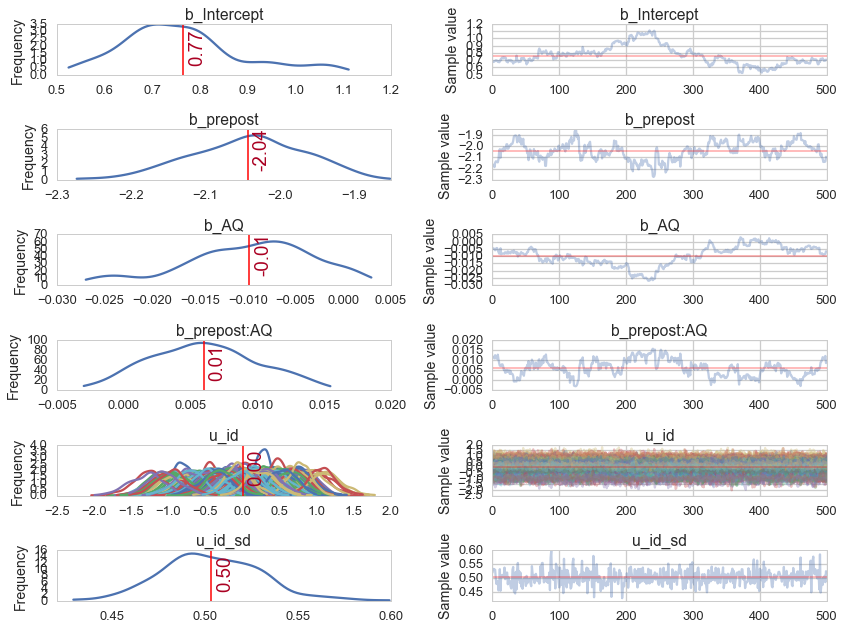

In [19]:
results.plot(burn_in=500);

In [39]:
# model comparison: https://pymc-devs.github.io/pymc3/notebooks/GLM-model-selection.html#Compare-Watanabe---Akaike-Information-Criterion-[WAIC]

import pymc3 as pm


pm.stats.waic(model=model.backend.model, trace=results.trace)

AttributeError: 'Model' object has no attribute 'observed_RVs'

## Compute diff scores for regular glm and plotting

In [25]:

dfmeans = dfmerged.groupby(['id', "prepost"]).acc.mean()
dfmeans = dfmeans.unstack().reset_index()
dfmeans["diff"] = dfmeans.post - dfmeans.pre
dfmeansAQ= dfmeans.merge(dfAQ, how='left', on='id')
# remove duplicates
dfmeansAQ = dfmeansAQ.drop_duplicates(subset="id")
print(len(dfmeansAQ))
dfmeansAQ.head()

282


prepost,id,post,pre,diff,Unnamed: 0,Unnamed: 0.1,sex,age,agec,1,...,48,49,50,AQ,AQlikert,AQattDetail,AQsocialSkill,AQattSwitch,AQcomm,AQimagination
0,18019.0,0.576271,0.186441,0.389831,146,146,Vrouw,11/96,NaN,3,...,1,2,3,17,115,29,21,22,22,21
1,19756.0,0.610169,0.288136,0.322034,4,4,Vrouw,10/96,NaN,4,...,2,1,2,22,120,30,26,26,21,17
2,20176.0,0.711864,0.237288,0.474576,272,272,Vrouw,19/06/1997,NaN,3,...,2,1,2,26,126,23,27,28,28,20
3,20179.0,0.593220,0.203390,0.389831,185,185,Vrouw,24/01/1997,NaN,2,...,2,3,1,19,104,27,18,24,19,16
4,20191.0,0.568966,0.103448,0.465517,240,240,Vrouw,04/1997,NaN,3,...,2,2,3,19,114,17,25,28,23,21


In [95]:
model = smf.glm(formula="diff ~ AQ", data=dfmeansAQ)
results = model.fit()
print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   diff   No. Observations:                  282
Model:                            GLM   Df Residuals:                      280
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                 0.0105566562614
Method:                          IRLS   Log-Likelihood:                 242.55
Date:                Fri, 16 Sep 2016   Deviance:                       2.9559
Time:                        02:33:10   Pearson chi2:                     2.96
No. Iterations:                     4                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.4468      0.018     25.478      0.000         0.412     0.481
AQ            -0.0015      0.001     -1.658      0.0

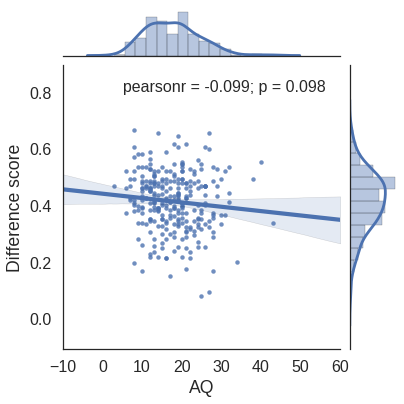

In [22]:
# plotting correlation

sns.set_context("poster")
sns.set_style("white")

f = sns.jointplot(x="AQ", y="diff", data=dfmeansAQ, kind="reg");
sns.axlabel("AQ","Difference score")
save_fig(f, "AQ_diff_scatter")

## Plot & test relation AQ subscales with Mooney performance

In [37]:
#subscale effects

# model formulation
fml = "acc ~ AQattDetail + AQattDetail:prepost + AQattSwitch + AQattSwitch:prepost + AQcomm + AQcomm:prepost \
+ AQsocialSkill + AQsocialSkill:prepost + AQimagination + AQimagination:prepost + prepost + \
blocknb + blocknb*prepost + sex"

# covariance structure
ex = sm.cov_struct.Exchangeable()
#link fu
fa = sm.families.Binomial(sm.families.links.logit)

model = sm.GEE.from_formula(fml, "id", dfmerged, cov_struct=ex, family=fa)
result = model.fit()
print(result.summary())
print(result.cov_struct.summary())

                               GEE Regression Results                              
Dep. Variable:                         acc   No. Observations:                34156
Model:                                 GEE   No. clusters:                      282
Method:                        Generalized   Min. cluster size:                 114
                      Estimating Equations   Max. cluster size:                 472
Family:                           Binomial   Mean cluster size:               121.1
Dependence structure:         Exchangeable   Num. iterations:                     9
Date:                      wo, 21 sep 2016   Scale:                           1.000
Covariance type:                    robust   Time:                         03:03:37
                                   coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------
Intercept                        1.1364      0.274

In [100]:
model = smf.glm(formula="diff ~ AQimagination + AQattDetail + AQattSwitch + AQcomm + AQsocialSkill", data=dfmeansAQ)
results = model.fit()
print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   diff   No. Observations:                  282
Model:                            GLM   Df Residuals:                      276
Model Family:                Gaussian   Df Model:                            5
Link Function:               identity   Scale:                 0.0102799215046
Method:                          IRLS   Log-Likelihood:                 248.33
Date:                Fri, 16 Sep 2016   Deviance:                       2.8373
Time:                        02:56:40   Pearson chi2:                     2.84
No. Iterations:                     4                                         
                    coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept         0.5239      0.048     10.927      0.000         0.430     0.618
AQimagination    -0.0050      0.002     -3.

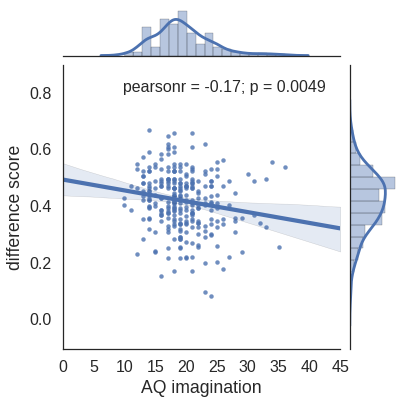

In [32]:
sns.set_context("poster")
sns.set_style("white")

f = sns.jointplot(x="AQimagination", y="diff", data=dfmeansAQ, kind="reg", robust=True);
sns.axlabel("AQ imagination","difference score")
save_fig(f,"imagination_diff_scatter")

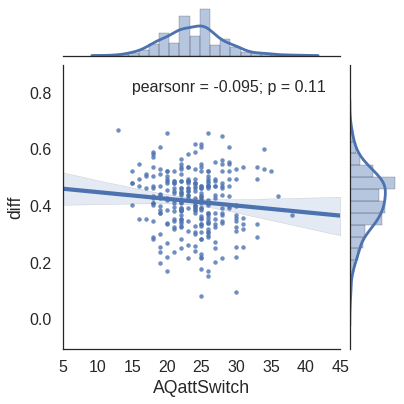

In [35]:
f = sns.jointplot(x="AQattSwitch", y="diff", data=dfmeansAQ, kind="reg");

In [32]:
# compute individual overall acc for plotting
dfgenmeans = dfmerged.groupby(['id']).acc.mean()
dfgenmeans = dfgenmeans.reset_index()
dfgenmeansAQ= dfgenmeans.merge(dfAQ, how='left', on='id')
# remove duplicates
dfgenmeansAQ = dfgenmeansAQ.drop_duplicates(subset="id")
print(len(dfgenmeansAQ))
dfgenmeansAQ.head()

282


,id,acc,Unnamed: 0,Unnamed: 0.1,sex,age,agec,1,2,3,...,48,49,50,AQ,AQlikert,AQattDetail,AQsocialSkill,AQattSwitch,AQcomm,AQimagination
0,18019,0.381356,146,146,Vrouw,11/96,NaN,3,1,2,...,1,2,3,17,115,29,21,22,22,21
1,19756,0.449153,4,4,Vrouw,10/96,NaN,4,2,1,...,2,1,2,22,120,30,26,26,21,17
2,20176,0.474576,272,272,Vrouw,19/06/1997,NaN,3,1,2,...,2,1,2,26,126,23,27,28,28,20
3,20179,0.398305,185,185,Vrouw,24/01/1997,NaN,2,2,1,...,2,3,1,19,104,27,18,24,19,16
4,20191,0.336207,240,240,Vrouw,04/1997,NaN,3,3,2,...,2,2,3,19,114,17,25,28,23,21


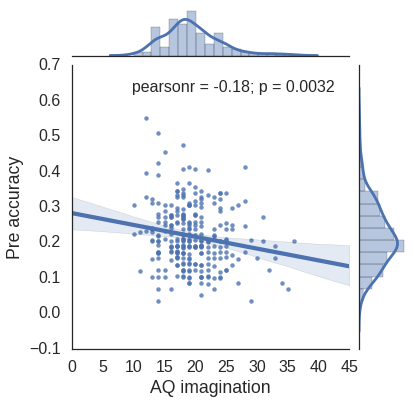

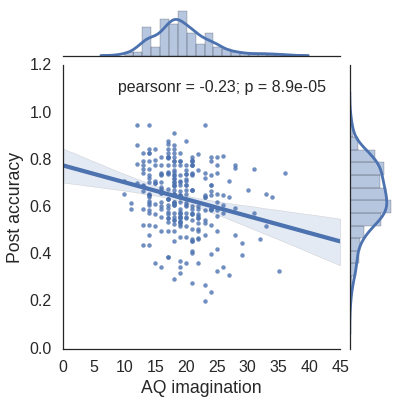

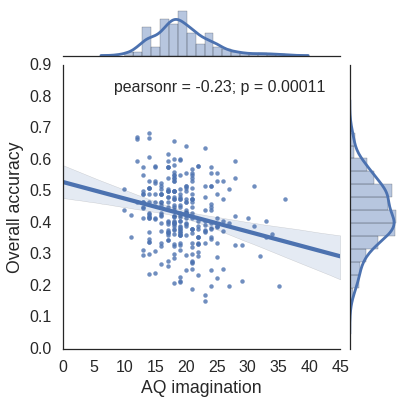

In [28]:
f = sns.jointplot(x="AQimagination", y="pre", data=dfmeansAQ, kind="reg");
sns.axlabel("AQ imagination","Pre accuracy")
save_fig(f, "imagination_pre_scatter")

f = sns.jointplot(x="AQimagination", y="post", data=dfmeansAQ, kind="reg");
sns.axlabel("AQ imagination","Post accuracy")
save_fig(f,"imagination_post_scatter")

f = sns.jointplot(x="AQimagination", y="acc", data=dfgenmeansAQ, kind="reg");
sns.axlabel("AQ imagination","Overall accuracy")
save_fig(f,"imagination_genacc_scatter")

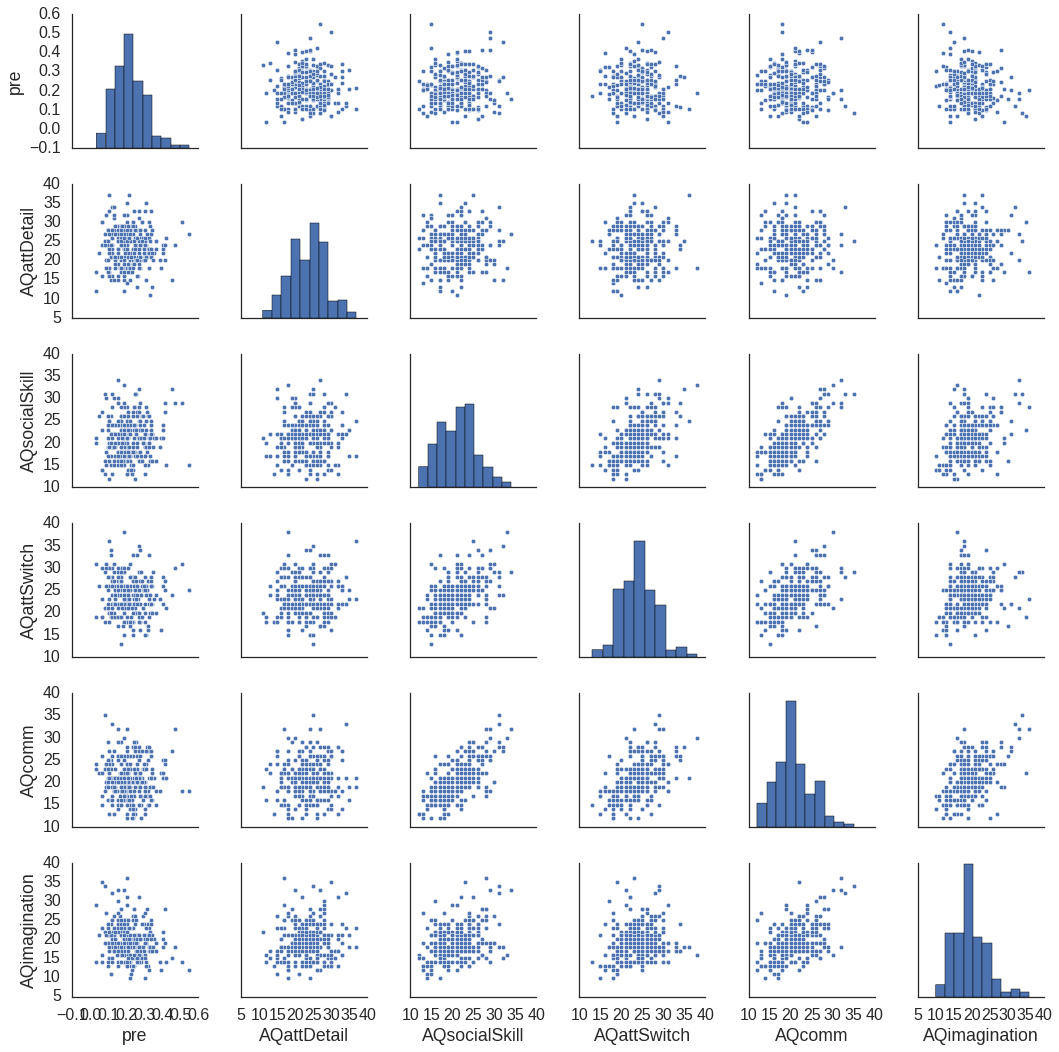

In [39]:
sns.pairplot(dfmeansAQ[["pre","AQattDetail", "AQsocialSkill", "AQattSwitch", "AQcomm", "AQimagination"]]);

# Study 2: Comparing Mooney performance in participants with ASD and TD controls

**!!! Don't run this again, import preprocessed data below (starting section 3.3) !!!**


## Preprocessing mooneyTD 

In [18]:
# From raw data to dataframe

with open('MooneyDataRawASD.csv', 'Ur') as f:
    data = list(list(rec) for rec in csv.reader(f, delimiter='\t'))

expandata=[]

print(len(data))
expandata.append(["id", "trialnb", "blocknb", "prepost", "stim", "response", "rt"])

#print(data[1][2])


for i,row in enumerate(data):
    
    
    if i==0:
        continue
    else:
        trials=row[2].split(']')
        
        
        for trial in trials:
            
            trial = trial.strip('[]')
            if trial=="": continue
            trial = trial.split(',')            
            expandata.append(trial)

print(len(expandata))

with open("datMooneyTD.csv", "wb") as f:
    writer = csv.writer(f)
    writer.writerows(expandata)
    


80
9481


## Read in preprocessed data and run correction key

In [26]:

df = pd.read_csv("dataMooney-aangepast.csv",)
df.head()

,id,trialnb,blocknb,prepost,stim,response,rt
0,102,0,0,pre,http://www.sandervandecruys.be/onlineExp/moone...,hond,5391
1,102,1,0,pre,http://www.sandervandecruys.be/onlineExp/moone...,man,7805
2,102,2,0,pre,http://www.sandervandecruys.be/onlineExp/moone...,vrouw,7894
3,102,3,0,pre,http://www.sandervandecruys.be/onlineExp/moone...,hond,7165
4,102,4,0,pre,http://www.sandervandecruys.be/onlineExp/moone...,strand,5215


In [28]:


def correct(df):


    rk = pd.read_csv("mooneyanswerkey.csv",delimiter='\t')
    acccol = []
    correctRespcol = []
    
    
    for rowNb, row in df.iterrows():


        answer = str(row['response'])
        acc=0
        
        

        if answer!='':
            answer=answer.lower()

            img= row['stim']
            
            
            img=img.split('http://www.sandervandecruys.be/onlineExp/mooneyTD/')
        
            img=img[1].strip('"')
            
            sols= rk.sol[rk['tt'] == img]
            sols=np.array(sols)[0].split(',')
            correctResp=sols

            for i in sols:
                i.strip()
                if fuzz.ratio(i,answer) > 70:
                    acc=1
                    break

        acccol.append(acc)
        correctRespcol.append(correctResp)

    df['acc'] = acccol
    df['correctResp'] = correctRespcol
    #print acccol
    return df

df = correct(df)
df.head()
df.to_csv('dataMooneyTDwithAcc.csv')




## Preprocessing done

In [9]:
df= pd.read_csv('ASD_Data/dataMooneyTDwithAcc.csv')

df.head()

,Unnamed: 0,id,trialnb,blocknb,prepost,stim,response,rt,acc,correctResp
0,0,102,0,0,pre,http://www.sandervandecruys.be/onlineExp/moone...,hond,5391.0,0,"['kikker', ' pad', ' toad', ' frog']"
1,1,102,1,0,pre,http://www.sandervandecruys.be/onlineExp/moone...,man,7805.0,0,"['hagedis', ' kameleon', ' leguaan', ' lizard'..."
2,2,102,2,0,pre,http://www.sandervandecruys.be/onlineExp/moone...,vrouw,7894.0,0,"['uil', ' owl', ' vogel', ' bird']"
3,3,102,3,0,pre,http://www.sandervandecruys.be/onlineExp/moone...,hond,7165.0,0,"['luipaard', ' jachtluipaard', ' jaguar', ' le..."
4,4,102,4,0,pre,http://www.sandervandecruys.be/onlineExp/moone...,strand,5215.0,0,"['kangoeroe', ' kangaroo']"


## Merge descriptive data with experimental data

In [10]:
dfDescriptive = pd.read_excel("ASD_Data/DescriptiveData.xls")
dfmerged= pd.merge(df, dfDescriptive, on='id')
print(len(dfmerged['id'].unique()))
print(len(dfmerged))
dfmerged.to_csv('ASD_Data/dataMooneywithDescriptive.csv')
df= dfmerged
df.head()

49
5880


,Unnamed: 0,id,trialnb,blocknb,prepost,stim,response,rt,acc,correctResp,...,TIQ,VIQ,PIQ,SRS_overall,SRS_consciousness,SRS_Cognition,SRS_Communication,SRS_Motivation,SRS_Preoccupation,ADOS: Above cut-off?
0,0,102,0,0,pre,http://www.sandervandecruys.be/onlineExp/moone...,hond,5391.0,0,"['kikker', ' pad', ' toad', ' frog']",...,107.0,97,117,37,37,41,37,38,45,NaN
1,1,102,1,0,pre,http://www.sandervandecruys.be/onlineExp/moone...,man,7805.0,0,"['hagedis', ' kameleon', ' leguaan', ' lizard'...",...,107.0,97,117,37,37,41,37,38,45,NaN
2,2,102,2,0,pre,http://www.sandervandecruys.be/onlineExp/moone...,vrouw,7894.0,0,"['uil', ' owl', ' vogel', ' bird']",...,107.0,97,117,37,37,41,37,38,45,NaN
3,3,102,3,0,pre,http://www.sandervandecruys.be/onlineExp/moone...,hond,7165.0,0,"['luipaard', ' jachtluipaard', ' jaguar', ' le...",...,107.0,97,117,37,37,41,37,38,45,NaN
4,4,102,4,0,pre,http://www.sandervandecruys.be/onlineExp/moone...,strand,5215.0,0,"['kangoeroe', ' kangaroo']",...,107.0,97,117,37,37,41,37,38,45,NaN


## Explore data: should we exclude people?

In [11]:
df["blocknb"]=df.blocknb + 1 #block starts from 0 instead of 1


for i, v in enumerate(df.columns):
    print(i, v)
print(df.dtypes)

0 Unnamed: 0
1 id
2 trialnb
3 blocknb
4 prepost
5 stim
6 response
7 rt
8 acc
9 correctResp
10 Initials
11 Age
12 Gender
13 Handedness
14 Group
15 TIQ
16 VIQ
17 PIQ
18 SRS_overall
19 SRS_consciousness
20 SRS_Cognition
21 SRS_Communication
22 SRS_Motivation
23 SRS_Preoccupation
24 ADOS: Above cut-off?
Unnamed: 0                int64
id                        int64
trialnb                   int64
blocknb                   int64
prepost                  object
stim                     object
response                 object
rt                      float64
acc                       int64
correctResp              object
Initials                 object
Age                       int64
Gender                   object
Handedness               object
Group                    object
TIQ                     float64
VIQ                       int64
PIQ                       int64
SRS_overall               int64
SRS_consciousness         int64
SRS_Cognition             int64
SRS_Communication         i

In [12]:
idmeans= df.groupby('id').acc.mean()
idmeans[idmeans<.2]

id
204    0.108333
229    0.100000
Name: acc, dtype: float64

**Participant 204 and 229 gave up early in the task and so did not reach .2 accuracy. They will be excluded from the rest of the analyses**

In [13]:
df= df.loc[df.id!=204]
df= df.loc[df.id!=229]

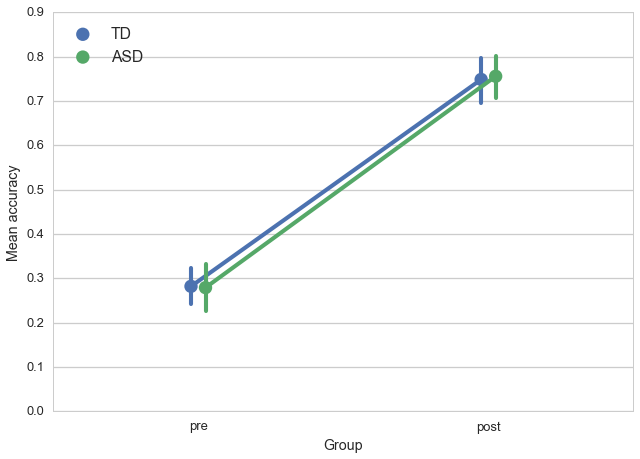

In [67]:
plt.figure(figsize=(8, 6))
f, ax = plt.subplots()
sns.pointplot(x="prepost", y="acc", hue="Group", units="id",data=df, dodge=True);
ax.legend(title="", ncol=1, loc="upper left", fontsize='medium');
ax.set(ylabel="Mean accuracy", xlabel="Group", ylim=(0,.9));
save_fig(f, "ASD_group_acc")

## Descriptive stats

Summarize accuracy data

In [69]:
pd.pivot_table(df, "acc", "id","prepost").describe().T
#pd.pivot_table(df, "acc", "id",["Group", "prepost"]).describe().T

,count,mean,std,min,25%,50%,75%,max
prepost,,,,,,,,
post,47.0,0.752128,0.111999,0.466667,0.683333,0.766667,0.833333,0.933333
pre,47.0,0.280496,0.101755,0.016667,0.225000,0.283333,0.350000,0.500000


In [117]:
#Gender
sex = df.groupby(['id']).Gender.apply(lambda x: x.iloc[0]) #number of males
print(len(sex[sex=="Man"]))


for i in ['Age', 'SRS_overall', 'TIQ', 'PIQ', 'VIQ']:
    grouped = df.groupby(['id','Group'])[i].mean().reset_index()
    print (grouped.groupby(['Group'])[i].describe())
    out = ttest_ind(grouped[grouped.Group=="ASD"][i], grouped[grouped.Group=="TD"][i], \
                    alternative='two-sided', usevar='pooled')
    print(i, "t-statistic:", out[0], "p-value:", out[1], "df:", out[2])

39
Group       
ASD    count    23.000000
       mean     14.043478
       std       1.491743
       min      11.000000
       25%      13.000000
       50%      14.000000
       75%      15.000000
       max      17.000000
TD     count    24.000000
       mean     14.375000
       std       1.279011
       min      13.000000
       25%      13.000000
       50%      14.000000
       75%      15.000000
       max      17.000000
Name: Age, dtype: float64
Age t-statistic: -0.81907990544 p-value: 0.417057697716 df: 45.0
Group       
ASD    count     23.000000
       mean      80.260870
       std       11.454326
       min       57.000000
       25%       72.000000
       50%       80.000000
       75%       83.000000
       max      104.000000
TD     count     24.000000
       mean      49.458333
       std        9.107948
       min       37.000000
       25%       44.250000
       50%       48.500000
       75%       56.250000
       max       67.000000
Name: SRS_overall, dtype: float6

## Do response counts (or false guesses) differ between phases/groups?

In [293]:
accsum = df.groupby(["id", "Group", "prepost"]).acc.sum().reset_index()
respcount = df.groupby(["id", "Group", "prepost"]).response.count().reset_index()
fa = pd.merge(accsum, respcount, on=["id","Group","prepost"])
fa["falseGuesses"] = fa.response-fa.acc
fa.head()

,id,Group,prepost,acc,response,falseGuesses
0,102,TD,post,45,60,15
1,102,TD,pre,17,60,43
2,103,TD,post,28,60,32
3,103,TD,pre,12,60,48
4,104,TD,post,54,58,4


In [296]:
lm = smf.ols("falseGuesses ~ prepost*Group", data=fa).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)
lm = smf.ols("response ~ prepost*Group", data=fa).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                     sum_sq  df           F        PR(>F)
prepost        10766.340426   1  151.753813  5.141447e-21
Group            145.746608   1    2.054329  1.552390e-01
prepost:Group     14.253777   1    0.200910  6.550646e-01
Residual        6385.148551  90         NaN           NaN
                    sum_sq  df          F    PR(>F)
prepost        1116.765957   1  11.515971  0.001028
Group           131.284690   1   1.353794  0.247691
prepost:Group    27.567376   1   0.284272  0.595229
Residual       8727.786232  90        NaN       NaN


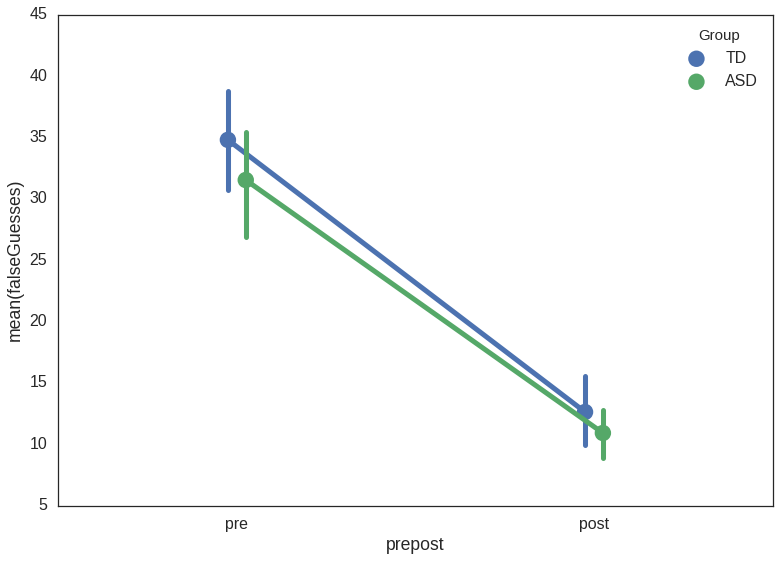

In [305]:
sns.pointplot(x="prepost", y="falseGuesses", hue="Group",data=fa, dodge=True, order=("pre","post"));

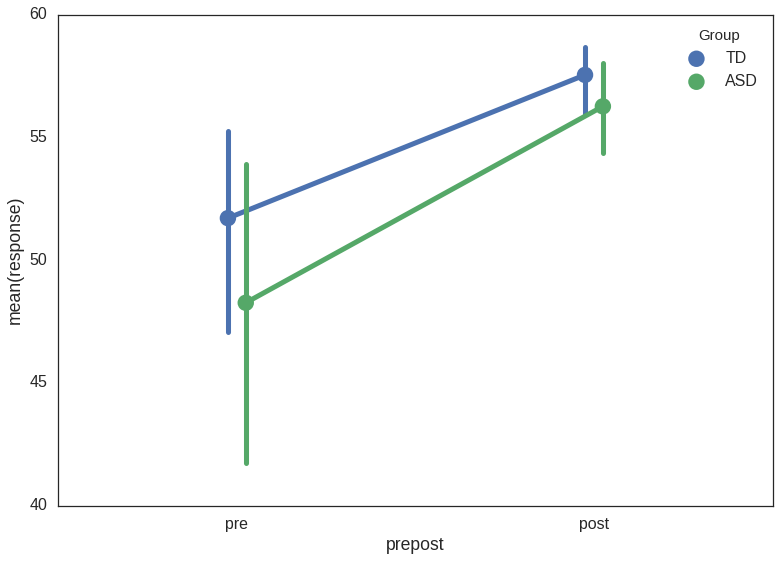

In [304]:
sns.pointplot(x="prepost", y="response", hue="Group",data=fa, dodge=True, order=("pre","post"));

## Does performance (acc) depend on group, prepost and/or block?

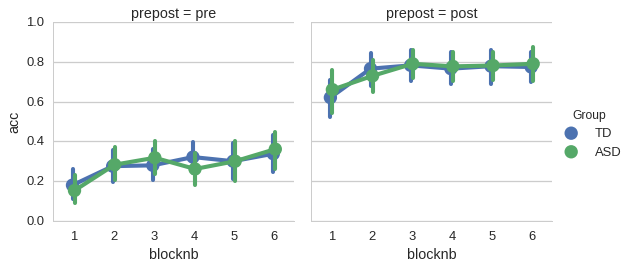

In [172]:
sns.factorplot(x="blocknb", y="acc",hue='Group', col='prepost', units="id",data=df, dodge=True);

In [14]:
# model formulation
fml = "acc ~ prepost * Group * blocknb" 
#"+ SRS_overall + SRS_overall:Group + TIQ + TIQ:Group"

ex = sm.cov_struct.Exchangeable() # covariance structure
fa = sm.families.Binomial(sm.families.links.logit) #link fu
model = sm.GEE.from_formula(fml, "id", df, cov_struct=ex, family=fa)
result = model.fit()

print(result.summary())
print(result.cov_struct.summary())

                               GEE Regression Results                              
Dep. Variable:                         acc   No. Observations:                 5640
Model:                                 GEE   No. clusters:                       47
Method:                        Generalized   Min. cluster size:                 120
                      Estimating Equations   Max. cluster size:                 120
Family:                           Binomial   Mean cluster size:               120.0
Dependence structure:         Exchangeable   Num. iterations:                     6
Date:                      vr, 23 sep 2016   Scale:                           1.002
Covariance type:                    robust   Time:                         13:53:21
                                         coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------------
Intercept                             

In [120]:
# model formulation
fml = "acc ~ prepost * Group + blocknb + blocknb*prepost + blocknb*Group + TIQ +\
 SRS_consciousness*prepost + SRS_Cognition*prepost + SRS_Communication*prepost +\
 SRS_Motivation*prepost + SRS_Preoccupation*prepost"

ex = sm.cov_struct.Exchangeable() # covariance structure
fa = sm.families.Binomial(sm.families.links.logit) #link fu
model = sm.GEE.from_formula(fml, "id", df, cov_struct=ex, family=fa)
result = model.fit()

print(result.summary())
print(result.cov_struct.summary())

                               GEE Regression Results                              
Dep. Variable:                         acc   No. Observations:                 5640
Model:                                 GEE   No. clusters:                       47
Method:                        Generalized   Min. cluster size:                 120
                      Estimating Equations   Max. cluster size:                 120
Family:                           Binomial   Mean cluster size:               120.0
Dependence structure:         Exchangeable   Num. iterations:                    15
Date:                      vr, 23 sep 2016   Scale:                           1.007
Covariance type:                    robust   Time:                         03:00:26
                                       coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------------
Intercept                           -1.457

In [175]:
# odds ratio: 
# http://stats.stackexchange.com/questions/133623/help-me-understand-adjusted-odds-ratio-in-logistic-regression
oddsratio = 1- (1/(1+np.exp(-2.088)))
oddsratio

0.11026864040567408

In [72]:
%%R -i df
m = glmer(acc ~ prepost * Group + (prepost | id), df, family=binomial)
m.null = glmer(acc ~ prepost + Group + (prepost | id), df, family=binomial)
lr.test(m, m.null, "interaction effect of prepost*AQ")

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: acc ~ prepost * Group + (prepost | id)
   Data: df

     AIC      BIC   logLik deviance df.resid 
  6381.9   6428.3  -3183.9   6367.9     5633 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.7445 -0.6612  0.3723  0.5803  2.8536 

Random effects:
 Groups Name        Variance Std.Dev. Corr 
 id     (Intercept) 0.2730   0.5224        
        prepostpre  0.1203   0.3469   -0.53
Number of obs: 5640, groups:  id, 47

Fixed effects:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)         1.19713    0.12731   9.403   <2e-16 ***
prepostpre         -2.20139    0.11660 -18.879   <2e-16 ***
GroupTD            -0.04129    0.17752  -0.233    0.816    
prepostpre:GroupTD  0.07675    0.16159   0.475    0.635    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) prp

In [71]:
%%R -i df
m = glmer(acc ~ prepost + Group + (prepost | id), df, family=binomial)
m.null = glmer(acc ~ prepost + (prepost | id), df, family=binomial)
lr.test(m, m.null, "Main effect of Group")

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: acc ~ prepost + Group + (prepost | id)
   Data: df

     AIC      BIC   logLik deviance df.resid 
  6380.1   6419.9  -3184.1   6368.1     5634 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.7236 -0.6581  0.3690  0.5771  2.8276 

Random effects:
 Groups Name        Variance Std.Dev. Corr 
 id     (Intercept) 0.2737   0.5232        
        prepostpre  0.1216   0.3488   -0.53
Number of obs: 5640, groups:  id, 47

Fixed effects:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  1.172326   0.115779  10.126   <2e-16 ***
prepostpre  -2.161996   0.081614 -26.490   <2e-16 ***
GroupTD      0.007417   0.145290   0.051    0.959    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
           (Intr) prpstp
prepostpre -0.443       
GroupTD    -0.637 -0.005
Likelihood ratio test for Main 

In [70]:
%%R -i df
m = glmer(acc ~ prepost + (prepost | id), df, family=binomial)
m.null = glmer(acc ~ 1 + (prepost | id), df, family=binomial)
lr.test(m, m.null, "Main effect of prepost")

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: acc ~ prepost + (prepost | id)
   Data: df

     AIC      BIC   logLik deviance df.resid 
  6378.1   6411.3  -3184.1   6368.1     5635 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.7241 -0.6578  0.3691  0.5772  2.8264 

Random effects:
 Groups Name        Variance Std.Dev. Corr 
 id     (Intercept) 0.2736   0.5230        
        prepostpre  0.1216   0.3487   -0.53
Number of obs: 5640, groups:  id, 47

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  1.17610    0.08927   13.18   <2e-16 ***
prepostpre  -2.16199    0.08160  -26.49   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
           (Intr)
prepostpre -0.578
Likelihood ratio test for Main effect of prepost:
  Chisq(1) = 132.47; p = 1.18e-30


## Fitting a generalized linear mixed model with bambi (Bayesian inference)


In [15]:

# Specify how the Bernoulli p parameter is distributed
prior_p = Prior('Beta', alpha=2, beta=2)

# The response variable distribution
prior = Prior('Bernoulli', p=prior_p)

# Construct the family
new_fam = Family('binomial', prior=prior, link="logit", parent='p')
# Specify how the Bernoulli p parameter is distributed
prior_p = Prior('Beta', alpha=2, beta=2)

# The response variable distribution
prior = Prior('Bernoulli', p=prior_p)

# Construct the family
new_fam = Family('binomial', prior=prior, link="logit", parent='p')

In [16]:
# Now it's business as usual
model = Model(df)
results = model.fit('acc ~ prepost * Group * blocknb', random='1|id', family=new_fam, samples=3000)

Applied log-transform to u_id_sd and added transformed u_id_sd_log_ to model.
Assigned NUTS to b_Intercept
Assigned NUTS to b_prepost
Assigned NUTS to b_Group
Assigned NUTS to b_prepost:Group
Assigned NUTS to b_blocknb
Assigned NUTS to b_prepost:blocknb
Assigned NUTS to b_Group:blocknb
Assigned NUTS to b_prepost:Group:blocknb
Assigned NUTS to u_id_sd_log_
Assigned NUTS to u_id
 [-------100%-------] 3000 of 3000 in 697.5 sec. | SPS: 4.3 | ETA: 0.0

/usr/local/lib/python2.7/dist-packages/bambi/models.py:218: UserWarning: Current Bayesian model has not been built yet; building it first before sampling begins.
  warnings.warn("Current Bayesian model has not been built yet; "


In [123]:
results.summary(500)


b_Intercept:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.695            0.190            0.016            [0.346, 1.046]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.337          0.559          0.697          0.829          1.044


b_prepost:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -2.285           0.220            0.018            [-2.741, -1.909]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -2.727         -2.448         -2.274         -2.112         -1.892


b_Group:

  Mean             SD               MC Error         95% HPD interval
  ----------

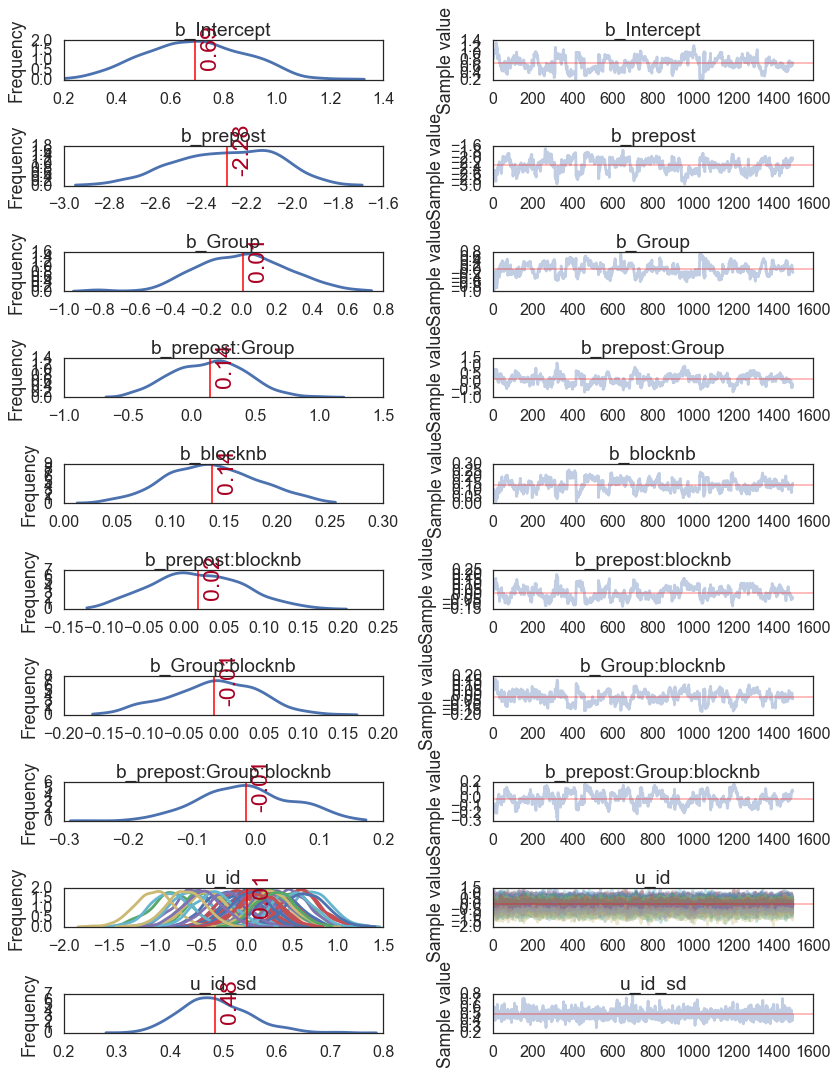

In [124]:
results.plot(burn_in=500);

In [17]:
# model comparison: https://pymc-devs.github.io/pymc3/notebooks/GLM-model-selection.html#Compare-Watanabe---Akaike-Information-Criterion-[WAIC]

import pymc3 as pm


pm.stats.waic(model=model.backend.model, trace=results.trace)

6292.9581623132908

## Interim conclusion

* There is a clear effect of the exposure to the "templates".
* There is also a learning effect (blocknb), but this is mainly carried by worse performance in the first block. Little learning happens after that. The learning effect is similar across phases (no interaction blocknb*phases) and groups (no interaction blocknb*group)
* There is no significant group effect or group*phase interaction.
* These conclusions hold also when correcting for IQ (matched) and SRS scores. IQ (specifically PIQ) may have an influence (see below).
* **The use of prior (top-down) information is not reduced or increased in ASD.**

## Compute diff scores (postmean minus premean)

In [73]:
print(len(df['id'].unique()))

def diffScore(df):
    
    after = df[df.prepost=='post'].acc.mean()
    before = df[df.prepost=='pre'].acc.mean()
    countsPre= df[df.prepost=='pre'].response.count()
    countsPost= df[df.prepost=='post'].response.count()
    fa= (df[df.prepost=='pre'].acc.sum())/float(countsPre)
    diff= after - before 
    SRS_overall = df['SRS_consciousness'].iloc[0]
    PIQ = df['PIQ'].iloc[0]
    TIQ = df['TIQ'].iloc[0]    
    group = df['Group'].iloc[0]
    #df['id'].iloc[0]
    dfout = pd.DataFrame(data=[(group, PIQ, TIQ, SRS_overall, before, after, diff, countsPre, countsPost, fa)], \
                         columns=['group','PIQ', 'TIQ','SRS_consciousness','pre', 'post', 'diff', \
                                  'countsPre', 'countsPost', 'fa'])
    return dfout

dfdiff = df.groupby('id').apply(diffScore)
dfdiff = dfdiff.reset_index()
dfdiff.head()

47


,id,level_1,group,PIQ,TIQ,SRS_consciousness,pre,post,diff,countsPre,countsPost,fa
0,102,0,TD,117,107.0,37,0.283333,0.750000,0.466667,60,60,0.283333
1,103,0,TD,114,111.5,47,0.200000,0.466667,0.266667,60,60,0.200000
2,104,0,TD,123,115.5,40,0.400000,0.900000,0.500000,49,58,0.489796
3,105,0,TD,103,107.0,40,0.116667,0.650000,0.533333,52,59,0.134615
4,106,0,TD,100,101.5,49,0.233333,0.866667,0.633333,58,60,0.241379


## Statistical test on the diff scores and on counts

In [241]:
# GLM test on diff score

model = smf.glm(formula="diff ~ group * SRS_overall * PIQ", data=dfdiff)

results = model.fit()
print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   diff   No. Observations:                   47
Model:                            GLM   Df Residuals:                       39
Model Family:                Gaussian   Df Model:                            7
Link Function:               identity   Scale:                0.00966927690589
Method:                          IRLS   Log-Likelihood:                 46.707
Date:                Sat, 17 Sep 2016   Deviance:                      0.37710
Time:                        01:14:56   Pearson chi2:                    0.377
No. Iterations:                     4                                         
                                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------
Intercept                      -0.2147      1.795     -0.120      0.905        -3.733     3.304
g

In [179]:
# GLM test of counts

model = smf.glm(formula="countsPre ~ group * SRS_overall * PIQ", data=dfdiff)
results = model.fit()
print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              countsPre   No. Observations:                   47
Model:                            GLM   Df Residuals:                       39
Model Family:                Gaussian   Df Model:                            7
Link Function:               identity   Scale:                   178.752309283
Method:                          IRLS   Log-Likelihood:                -184.18
Date:                Fri, 16 Sep 2016   Deviance:                       6971.3
Time:                        23:37:16   Pearson chi2:                 6.97e+03
No. Iterations:                     4                                         
                                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------
Intercept                    -249.4742    244.086     -1.022      0.307      -727.874   228.926
g

## Make violin plots for inspecting differences and distributions

In [42]:
# reshape data
dfmelted = pd.melt(dfdiff, id_vars=['id','group'], value_vars=['pre', 'post'], var_name=["prepost"], value_name='acc')
dfmelted.head()

,id,group,prepost,acc
0,102,TD,pre,0.283333
1,103,TD,pre,0.200000
2,104,TD,pre,0.400000
3,105,TD,pre,0.116667
4,106,TD,pre,0.233333


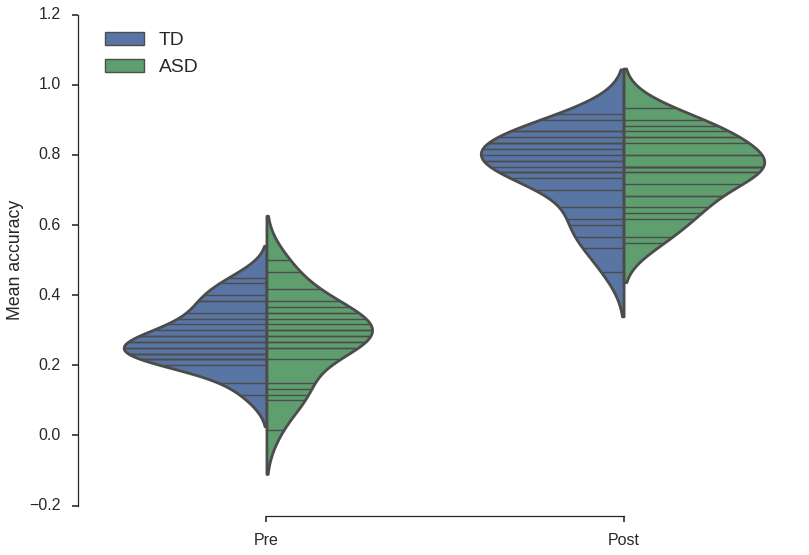

In [43]:
sns.set_context("poster")
sns.set_style("ticks")
f, ax = plt.subplots()
sns.violinplot(x="prepost", y="acc", hue="group", data=dfmelted, split=True, inner="stick");
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = 'Pre'
labels[1] = 'Post'
ax.set_xticklabels(labels)
sns.despine(offset=10, trim=True);
ax.legend(title="", ncol=1, loc="upper left", fontsize='medium');
ax.set(ylabel="Mean accuracy", xlabel="");
save_fig(f,"ASD_acc_prepost")

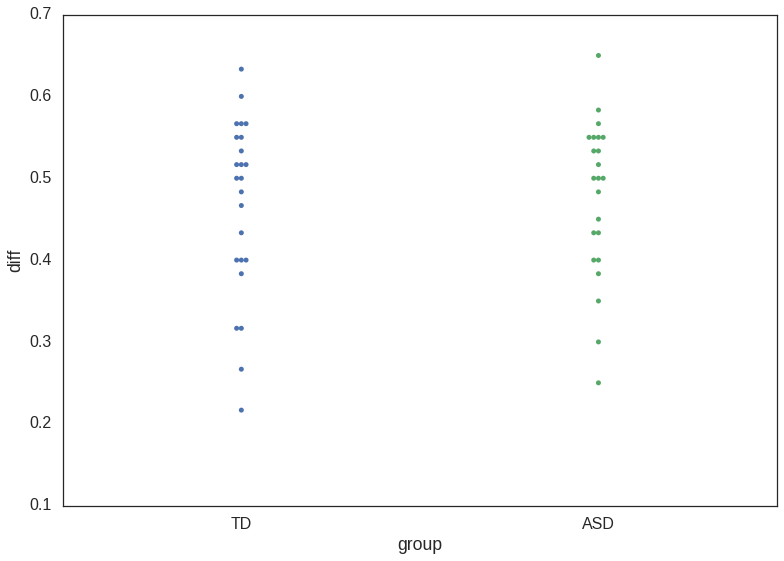

In [47]:
# plot individual data (diff scores)
sns.swarmplot(x="group", y="diff", data=dfdiff);

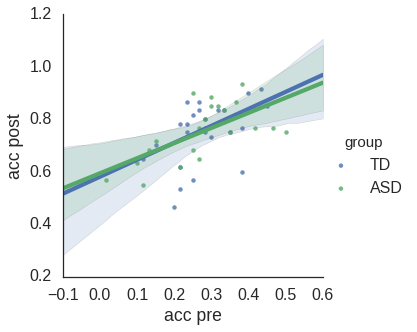

In [50]:
# scatterplot of pre vs post accuracy ("paired observations")
dfwide= pd.pivot_table(data=dfmelted, values=["acc"], index=['id'],columns=['prepost']).reset_index()
dfwide.columns = [' '.join(col).strip() for col in dfwide.columns.values]
dfwide= pd.merge(dfwide, dfmelted[['id','group']], how='inner', on='id').drop_duplicates(subset="id")
dfwide.head()
sns.lmplot(x="acc pre", y="acc post",hue="group", robust=True, data=dfwide);

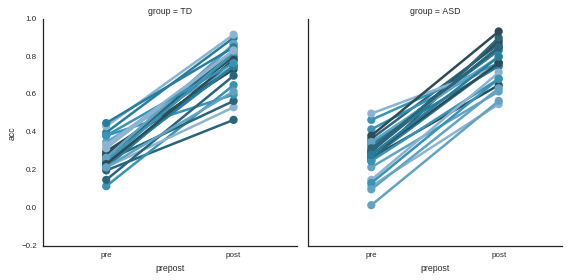

In [63]:
# Plotting paired observations per id
sns.set_context("paper")
sns.factorplot(x="prepost", y="acc",hue="id", col="group", kind="point",\
               join=True, legend=False, palette=sns.color_palette("PuBuGn_d"), data=dfmelted)

## Check correlations with SRS

AttributeError: 'module' object has no attribute 'axlabel'

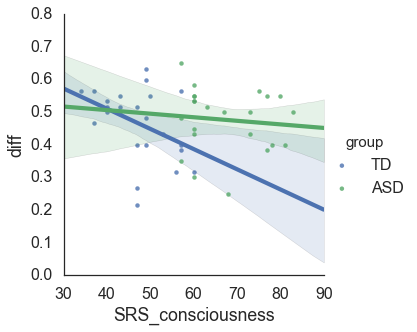

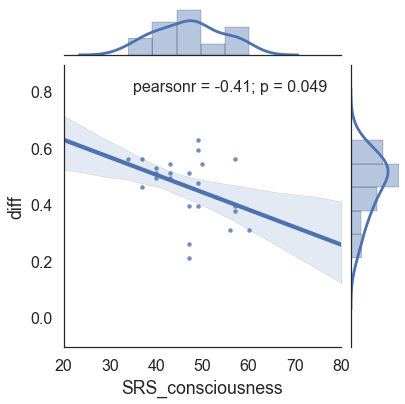

In [75]:
# plotting correlation

sns.set_context("poster")
sns.set_style("white")
sns.lmplot(x="SRS_consciousness", y="diff", hue='group', data=dfdiff);
f = sns.jointplot(x="SRS_consciousness", y="diff", data=dfdiff[dfdiff.group!="ASD"], kind="reg");
sns.axlabel("SRS consciousness","Difference score")
save_fig(f,"SRS_consciousness_diff_scatter")

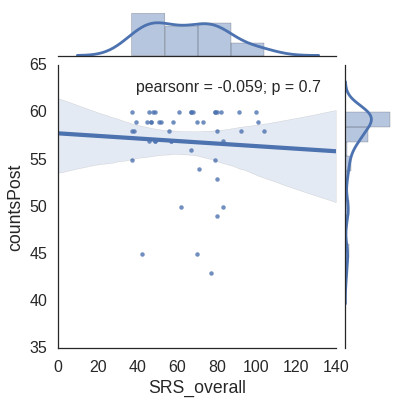

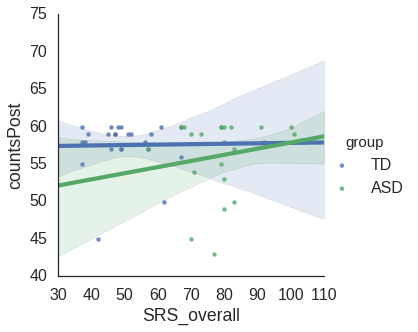

In [199]:
sns.jointplot(x="SRS_overall", y="countsPost", data=dfdiff, kind="reg");
sns.lmplot(x="SRS_overall", y="countsPost", hue='group', data=dfdiff);

## Interim conclusion

* No notable correlations between SRS_overall & diff, pre/postmean, counts 

## Check correlations with IQ

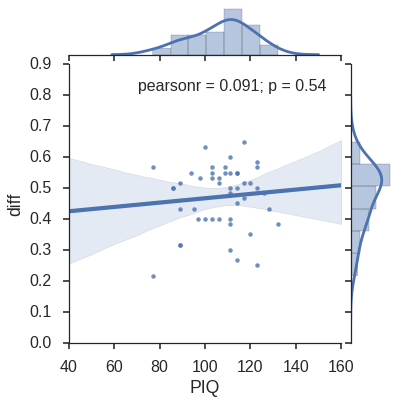

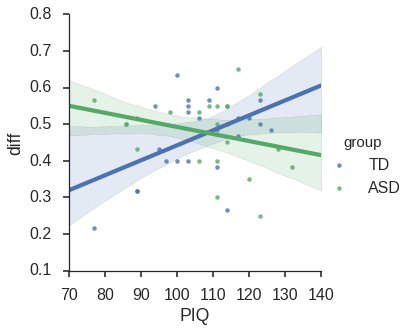

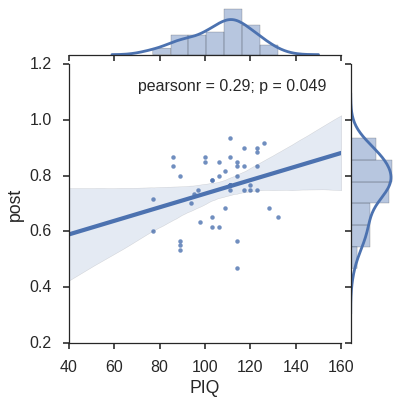

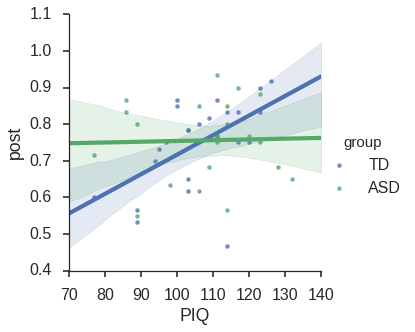

In [207]:
sns.jointplot(x="PIQ", y="diff", data=dfdiff, kind="reg");
sns.lmplot(x="PIQ", y="diff", hue='group', data=dfdiff);
sns.jointplot(x="PIQ", y="post", data=dfdiff, kind="reg");
sns.lmplot(x="PIQ", y="post", hue='group', data=dfdiff);

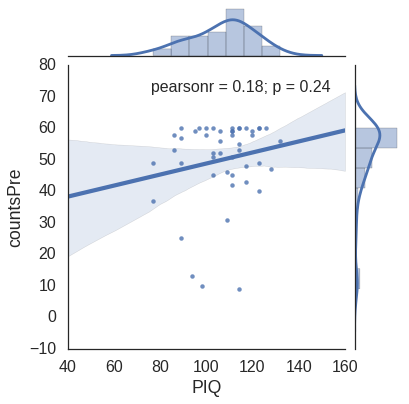

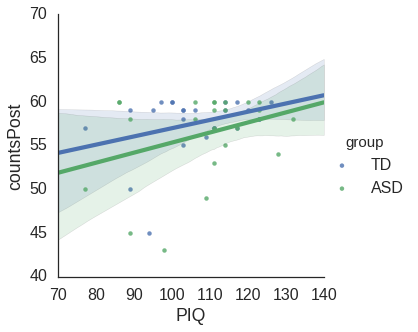

In [202]:
sns.jointplot(x="PIQ", y="countsPre", data=dfdiff, kind="reg");
sns.lmplot(x="PIQ", y="countsPost", hue='group', data=dfdiff);

## Interim conclusion

* No notable correlations with IQ in premean or counts
* There may be a positive correlation between (post)acc and PIQ (more so in the TD group, but this may be because not enough range in PIQ). This will likely not survive multiple comparison correction.

# TODO

*  


In [ ]:
# adapting labels
labels = [str(int(item.get_text())+1) for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
